In [1]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure TensorFlow for GPU usage
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if no GPU is found

input_size = 224
num_frame = 16
batch_size = 4 * strategy.num_replicas_in_sync  # Declare batch size

# Define paths
train_uc_set = '/home/jovyan/vol-1/enterface_train'
val_uc_set = '/home/jovyan/vol-1/enterface_val'
test_uc_set = '/home/jovyan/vol-1/enterface_test'

# Define the emotion labels from the file names
uc_label2id = {'anger': 0, 'happiness': 1, 'surprise': 2, 'disgust': 3, 'fear': 4, 'sadness': 5}
uc_id2label = {v: k for k, v in uc_label2id.items()}

import pandas as pd
def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion = video_file.split('_')[1]  # Extract emotion class from filename
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    total_frames = len(vr)
    frame_indices = np.linspace(0, total_frames - 1, num=num_frame, dtype=int)
    frames = vr.get_batch(frame_indices).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  # Change to float32
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  # Set the correct shape
    return video, tf.cast(label, dtype=tf.float32)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan/vol-1/pretrainedmodel"
pretrained_model = tf.saved_model.load(model_path)

# Create a custom Keras layer to wrap the pre-trained model
class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Define the model within the strategy scope
with strategy.scope():
    # Define the downstream model
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))  # Input shape
    x = TFSMLayer(pretrained_model)(inputs)

    # Define the output layer
    outputs = layers.Dense(len(uc_label2id), dtype='float32', activation=None)(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name="linear_probe_model")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,  # Reduced learning rate to avoid OOM issues
            weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc")
        ]
    )

# Print the summary of the model to verify the structure
model.summary()

# Training
history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=50,
)


2024-11-06 10:49:05.229039: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: A100-SXM4-40GB MIG 0g.5gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-11-06 10:49:06.790625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2983 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 0g.5gb, pci bus id: 0000:07:00.0, compute capability: 8.0


Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer (TFSMLayer)      (None, 400)               0         
                                                                 
 dense (Dense)               (None, 6)                 2406      
                                                                 
Total params: 2406 (9.40 KB)
Trainable params: 2406 (9.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-11-06 10:49:20.930032: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 689
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2024-11-06 10:49:31.626262: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbc5d6d8600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-06 10:49:31.626300: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): A100-SXM4-40GB MIG 0g.5gb, Compute Capability 8.0
2024-11-06 10:49:31.953160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-06 10:49:34.037303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-11-06 10:49:39.596307: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


172/172 [==============================] - ETA: 0s - loss: 1.8032 - acc@1: 0.2413 - acc: 0.5872

2024-11-06 10:52:23.385250: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 228
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

172/172 [==============================] - 247s 1s/step - loss: 1.8032 - acc@1: 0.2413 - acc: 0.5872 - val_loss: 1.7505 - val_acc@1: 0.2719 - val_acc: 0.6491
Epoch 2/50
172/172 [==============================] - 237s 1s/step - loss: 1.6306 - acc@1: 0.2994 - acc: 0.6933 - val_loss: 1.7081 - val_acc@1: 0.3158 - val_acc: 0.6886
Epoch 3/50
172/172 [==============================] - 231s 1s/step - loss: 1.5618 - acc@1: 0.3605 - acc: 0.7427 - val_loss: 1.6849 - val_acc@1: 0.3026 - val_acc: 0.7500
Epoch 4/50
172/172 [==============================] - 222s 1s/step - loss: 1.5070 - acc@1: 0.3852 - acc: 0.7733 - val_loss: 1.6664 - val_acc@1: 0.3246 - val_acc: 0.7544
Epoch 5/50
172/172 [==============================] - 226s 1s/step - loss: 1.4671 - acc@1: 0.4142 - acc: 0.7863 - val_loss: 1.6213 - val_acc@1: 0.3377 - val_acc: 0.7675
Epoch 6/50
172/172 [==============================] - 228s 1s/step - loss: 1.4382 - acc@1: 0.3953 - acc: 0.7936 - val_loss: 1.6044 - val_acc@1: 0.3553 - val_acc: 0.76

In [2]:
evaluation = model.evaluate(test_uc_ds, return_dict=True)

accuracy = evaluation['acc'] 
top3_accuracy = evaluation.get('acc@1') 

print(f"Accuracy: {accuracy}")
print(f"Top-3 Accuracy: {top3_accuracy}")


2024-11-06 14:02:19.978483: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 231
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:9"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

57/57 [==============================] - 56s 961ms/step - loss: 1.4574 - acc@1: 0.3816 - acc: 0.8070
Accuracy: 0.8070175647735596
Top-3 Accuracy: 0.3815789520740509


1/1 [==============================] - 0s 141ms/step


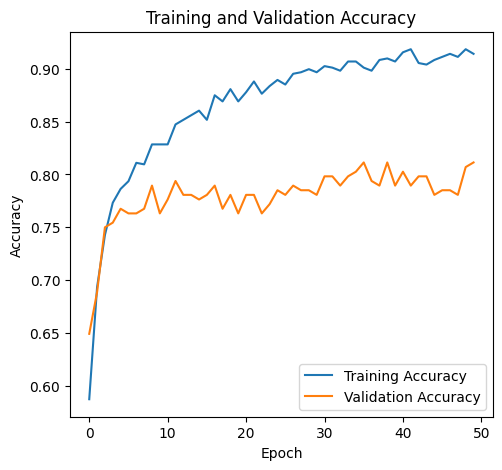

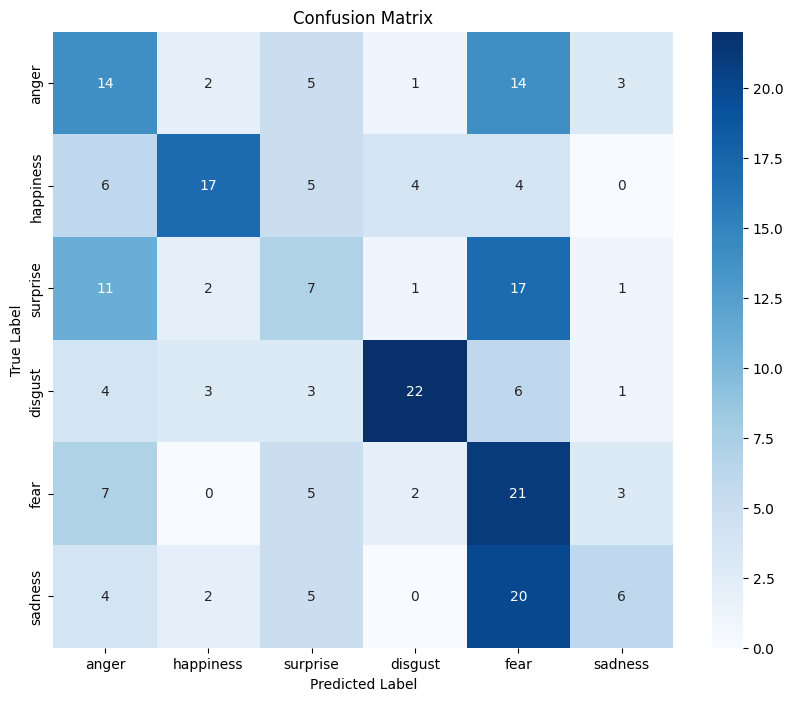

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# Plot accuracy and loss for training and validation
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    


# Call the function to plot accuracy and loss
plot_training_history(history)

# Generate predictions and plot confusion matrix
def plot_confusion_matrix(model, dataset, label_mapping):
    # Generate predictions
    y_true = []
    y_pred = []
    
    for videos, labels in dataset:
        predictions = model.predict(videos)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=list(label_mapping.keys()))
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title("Confusion Matrix")
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(model, test_uc_ds, uc_label2id)
